<a href="https://colab.research.google.com/github/oxanaRC/CE902/blob/main/Random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

14.08.21
Upload three csv files:
1. dataset for training and testing 
2. dataset for validation
3. dataset for records identification ('location key', 'postal code' and 'district) - this to be joined with data after predictions were done so the quality of predictions could be analysed by location.



In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))


Saving train_and_test_data.csv to train_and_test_data.csv
Saving locations_categorical_features.csv to locations_categorical_features.csv
Saving validation_data.csv to validation_data.csv
User uploaded file "train_and_test_data.csv" with length 223688221 bytes
User uploaded file "locations_categorical_features.csv" with length 27878177 bytes
User uploaded file "validation_data.csv" with length 7581347 bytes


In [2]:
import pandas as pd
from pathlib import Path

In [140]:
df_location_categories = pd.read_csv("locations_categorical_features.csv") 
df_location_categories

,location_key,postcode,district
0,100000460_235813700_173697830,IP28 6QS,ST EDMUNDSBURY
1,100000900_306645770_193413260,PO2 9AE,PORTSMOUTH
2,100001709_306232250_192988720,PO2 8NT,PORTSMOUTH
3,100002450_241021470_178393000,IP33 3UF,ST EDMUNDSBURY
4,100002500_240933210_178314290,IP33 3UE,ST EDMUNDSBURY
...,...,...,...
563834,99996430_240804040_178195840,IP33 3UN,WEST SUFFOLK
563835,99996800_303056370_189735890,PO16 9PA,FAREHAM
563836,99998470_302856560_189531620,PO16 9UH,FAREHAM
563837,99998690_306575700_193341460,PO2 9BS,PORTSMOUTH


In [141]:
df_train_test_data = pd.read_csv("train_and_test_data.csv") 
df_train_test_data

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,this_price_per_bedroom,compare_ppd_re_hist_median_3mnths,compare_ppd_re_hist_median_4mnths,price_paid
0,1,L,T,23.0,110.178111,0.671216,96.0,0.5,0.9,60000.000000,56187.500000,7,26510768000,718540000,11622296000,53.489825,-2.358860,100000.0,66.666667,77.975528,100000.0
1,1,L,S,24.0,78.275669,0.320619,15.0,10.8,9.4,79166.666667,79000.000000,23,26539970000,542647000,11902983000,53.528583,-2.270335,79500.0,0.421053,0.632911,79500.0
2,1,L,F,12.0,85.979811,0.584296,20.0,11.5,9.8,73416.666667,64341.666667,4,16016690000,25505656000,21724217000,52.637255,1.298314,128000.0,74.347333,98.937961,128000.0
3,1,L,F,3.0,89.636307,0.452391,13.0,9.7,8.3,101666.666667,101666.666667,14,6296533000,26014878000,18039516000,51.868112,0.544362,170000.0,67.213115,67.213115,170000.0
4,1,F,S,6.0,55.701643,1.752959,14.0,11.9,11.0,136250.000000,168104.166667,18,4111570000,27468619000,16632627000,51.236727,-0.560636,655000.0,380.733945,289.639361,655000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1144234,5,F,D,1.0,0.000000,0.000000,0.0,0.0,0.0,87250.000000,92500.000000,16,18126308000,28825475000,18214946000,50.896436,-2.576097,114000.0,30.659026,23.243243,570000.0
1144235,5,F,D,24.0,97.697793,1.639435,97.0,1.9,2.8,105000.000000,107500.000000,4,25424316000,711278000,10659618000,53.417210,-2.246727,178000.0,69.523810,65.581395,890000.0
1144236,5,F,S,6.0,193.121503,1.094252,26.0,8.7,8.3,89750.000000,92500.000000,9,8815989000,34831047000,24742056000,50.868112,0.567342,65600.0,-26.908078,-29.081081,328000.0
1144237,5,F,D,6.0,46.650826,2.156095,27.0,9.5,8.1,57750.000000,57750.000000,2,29718009000,3717254000,14712579000,53.731672,-2.624259,42800.0,-25.887446,-25.887446,214000.0


In [142]:
df_validation_data = pd.read_csv("validation_data.csv") 
df_validation_data

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,this_price_per_bedroom,compare_ppd_re_hist_median_3mnths,compare_ppd_re_hist_median_4mnths,price_paid
0,1,L,F,54.0,92.304597,0.543902,36.0,11.4,9.6,285000.000000,326250.000000,26,770794900,26771245000,16701868000,51.446749,-0.137157,314000.0,10.175439,-3.754789,314000.0
1,1,F,T,35.0,78.178630,0.086689,36.0,8.9,8.4,113333.333333,119166.666667,26,2095469000,26684681000,17218624000,51.564821,0.123801,225000.0,98.529412,88.811189,225000.0
2,1,L,F,11.0,67.921534,0.836103,32.0,7.6,7.0,92750.000000,80000.000000,26,10333301000,30370523000,19027695000,50.830953,-1.173732,120000.0,29.380054,50.000000,120000.0
3,1,L,F,60.0,104.272807,0.530036,60.0,9.2,8.7,219083.333333,240000.000000,26,502176000,26527685000,16536000000,51.478533,-0.121591,500000.0,128.223659,108.333333,500000.0
4,1,L,F,9.0,125.415966,0.658497,39.0,9.0,7.6,42000.000000,42908.333333,26,32407942000,6604266000,17029935000,53.856740,-3.027827,52000.0,23.809524,21.188580,52000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38522,5,F,D,6.0,10.055754,4.727453,9.0,9.8,8.5,52500.000000,55333.333333,26,22886393000,4770220000,7212565000,53.060015,-2.388207,78750.0,50.000000,42.319277,393750.0
38523,5,F,S,1.0,62.208157,4.362943,38.0,7.5,7.3,92333.333333,97000.000000,26,8821511000,25299709000,18394460000,52.085717,0.720703,186000.0,101.444043,91.752577,930000.0
38524,5,F,D,1.0,46.891396,2.650615,14.0,9.6,8.8,105520.833333,106666.666667,26,6938065000,27433863000,19483321000,51.800099,0.725616,112000.0,6.140178,5.000000,560000.0
38525,5,F,T,9.0,103.448709,1.487324,16.0,10.7,10.2,163958.333333,158791.666667,26,7548684000,32765304000,21992537000,50.834805,-0.137428,108400.0,-33.885642,-31.734453,542000.0


In [143]:
#remove outliers
#df_train_test_data=df_train_test_data[(df_train_test_data['num_of_beds'] <=5) & (df_train_test_data['price_paid'] > 10000) & (df_train_test_data['price_paid'] <1000000) ]
#df_validation_data=df_validation_data[(df_validation_data['num_of_beds'] <=5) & (df_validation_data['price_paid'] > 10000) & (df_validation_data['price_paid'] <1000000) ]
#remove outliers
df_train_test_data=df_train_test_data[(df_train_test_data['closest_sch_distance'] !=0) ]
df_validation_data=df_validation_data[(df_validation_data['closest_sch_distance'] !=0) ]
#-------------------------------------------------------------------------------------------------------
df_train_test_data=df_train_test_data[(df_train_test_data['compare_ppd_re_hist_median_3mnths'] <=100) ]
df_train_test_data=df_train_test_data[(df_train_test_data['compare_ppd_re_hist_median_4mnths'] <=100) ]
df_validation_data=df_validation_data[(df_validation_data['compare_ppd_re_hist_median_3mnths']<=100) ]
df_validation_data=df_validation_data[(df_validation_data['compare_ppd_re_hist_median_4mnths'] <=100) ]

In [144]:
#remove columns: 'this_price_per_bedroom',	'compare_ppd_re_hist_median_3mnths',	'compare_ppd_re_hist_median_4mnths'
df_train_test_data=df_train_test_data.drop(['this_price_per_bedroom', 'compare_ppd_re_hist_median_3mnths','compare_ppd_re_hist_median_4mnths'], axis = 1)
df_validation_data=df_validation_data.drop(['this_price_per_bedroom', 'compare_ppd_re_hist_median_3mnths','compare_ppd_re_hist_median_4mnths'], axis = 1)


In [145]:
estateTypes=df_train_test_data['estate_type'].unique()
estateTypes

array(['L', 'F'], dtype=object)

In [146]:
df_train_test_data['estate_type'] =df_train_test_data['estate_type'].map({'F':'2',
                             'L':'1'})
df_validation_data['estate_type'] =df_validation_data['estate_type'].map({'F':'2',
                             'L':'1'})


In [147]:
propertyTypes=df_train_test_data['property_type'].unique()
propertyTypes

array(['T', 'S', 'F', 'D'], dtype=object)

In [148]:
df_train_test_data['property_type'] =df_train_test_data['property_type'].map({'O':'5','D':'4','S':'3','T':'2','F':'1'})
df_validation_data['property_type'] =df_validation_data['property_type'].map({'O':'5','D':'4','S':'3','T':'2','F':'1'})

              

In [149]:
#shuffle the train_test dataset
df_train_test_data = df_train_test_data.sample(frac = 1)
df_train_test_data

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,price_paid
255358,2,2,2,22.0,118.533804,0.694837,96.0,0.5,0.9,56187.500000,62500.000000,6,26391764000,699941000,11487695000,53.477598,-2.356858,107000.0
142023,2,1,1,49.0,103.747097,1.213498,64.0,9.7,8.7,385000.000000,253333.333333,12,424984000,25605142900,15625827000,51.545234,-0.201628,400000.0
1022544,4,2,4,3.0,50.134732,0.647614,19.0,10.6,9.5,97500.000000,104375.000000,11,12980637900,14157146000,3097807000,52.267988,-1.610974,460000.0
860276,3,2,2,4.0,96.393413,0.918479,13.0,9.7,10.0,68333.333333,61250.000000,4,18389856000,28370877000,17864941000,50.941123,-2.645607,180000.0
1097601,4,2,4,2.0,17.445784,4.124643,15.0,9.7,8.5,80416.666667,75000.000000,21,22163923000,28154699000,18670484000,51.024975,-3.256622,335000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
889212,3,2,4,10.0,42.021981,0.227583,4.0,14.2,15.0,83333.333333,83333.333333,3,14608754000,17861748000,7041036000,51.875015,-2.205390,225000.0
194244,2,2,2,6.0,74.009077,1.434131,28.0,10.1,10.9,79666.666667,82500.000000,19,10140375900,16911938000,6015984000,52.062468,-1.344787,170000.0
813524,3,2,3,5.0,68.222875,2.044651,22.0,0.7,1.6,52500.000000,52500.000000,1,42023694000,16537610000,27889360000,54.917085,-2.913354,120000.0
264462,2,2,2,4.0,43.839995,0.703141,12.0,12.1,10.5,73333.333333,86000.000000,5,16992108000,10009554000,7752334000,52.943973,-1.044965,156000.0


In [150]:
dataset = df_train_test_data.values
dataset

array([[2, '2', '2', ..., 53.477598, -2.3568580000000003, 107000.0],
       [2, '1', '1', ..., 51.545234, -0.201628, 400000.0],
       [4, '2', '4', ..., 52.267988, -1.610974, 460000.0],
       ...,
       [3, '2', '3', ..., 54.917085, -2.913354, 120000.0],
       [2, '2', '2', ..., 52.943973, -1.044965, 156000.0],
       [3, '2', '3', ..., 52.583315, -1.1347049999999999, 180000.0]],
      dtype=object)

In [151]:
X1 = dataset[:,0:17]
Y1 = dataset[:,17]
#all features

In [152]:
validation_dataset=df_validation_data.values
validation_dataset

array([[1, '1', '1', ..., 51.446749, -0.137157, 314000.0],
       [1, '2', '2', ..., 51.564821, 0.123801, 225000.0],
       [1, '1', '1', ..., 50.830953, -1.173732, 120000.0],
       ...,
       [5, '2', '4', ..., 51.800098999999996, 0.725616, 560000.0],
       [5, '2', '2', ..., 50.834804999999996, -0.137428, 542000.0],
       [5, '2', '4', ..., 50.778189000000005, 0.102345, 412000.0]],
      dtype=object)

In [153]:
X_Validation=validation_dataset[:,0:17]
Y_Validation =validation_dataset[:,17]

In [154]:
from sklearn import preprocessing

In [155]:
min_max_scaler = preprocessing.MinMaxScaler()

In [156]:
X1_scale = min_max_scaler.fit_transform(X1)
X1_scale

array([[0.25      , 1.        , 0.33333333, ..., 0.30447749, 0.60196917,
        0.4485862 ],
       [0.25      , 0.        , 0.        , ..., 0.41480717, 0.2688848 ,
        0.73749362],
       [0.75      , 1.        , 1.        , ..., 0.0807887 , 0.39346695,
        0.54857155],
       ...,
       [0.5       , 1.        , 0.66666667, ..., 0.74177397, 0.85009562,
        0.37398821],
       [0.25      , 1.        , 0.33333333, ..., 0.20488636, 0.50998746,
        0.62444475],
       [0.5       , 1.        , 0.66666667, ..., 0.1404422 , 0.44782032,
        0.61241515]])

In [157]:

print(min(Y1))
print(max(Y1))

14500.0
999999.0


In [158]:
X_Validation_scale = min_max_scaler.transform(X_Validation)
X_Validation_scale

array([[0.        , 0.        , 0.        , ..., 0.44349627, 0.2519088 ,
        0.74613592],
       [0.        , 1.        , 0.33333333, ..., 0.45727387, 0.27226104,
        0.7811172 ],
       [0.        , 0.        , 0.        , ..., 0.5055068 , 0.14576315,
        0.6071836 ],
       ...,
       [1.        , 1.        , 1.        , ..., 0.51765457, 0.31281625,
        0.86179018],
       [1.        , 1.        , 0.33333333, ..., 0.58455457, 0.14642713,
        0.7460996 ],
       [1.        , 1.        , 1.        , ..., 0.62369645, 0.13666815,
        0.77824104]])

In [159]:
print(min(Y_Validation))
print(max(Y_Validation))

18000.0
999000.0


In [160]:
from sklearn.model_selection import train_test_split

In [161]:
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1_scale, Y1, test_size=0.1)

In [162]:
print(X1_train.shape, X1_test.shape, Y1_train.shape, Y1_test.shape)

(922946, 17) (102550, 17) (922946,) (102550,)


In [163]:
from sklearn.ensemble import RandomForestRegressor

In [186]:
regr1 = RandomForestRegressor(max_depth=13, random_state=0)
regr1.fit(X1_train, Y1_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=13, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [187]:
prediction1=regr1.predict(X1_test)
#print(prediction1)

In [188]:
prediction_df1 = pd.DataFrame(min_max_scaler.inverse_transform(X1_test)) 
prediction_df1.columns =['num_of_beds', 'estate_type', 'property_type','num_of_sec_sch','score_disadv','closest_sch_distance', 'closest_disadv_prct',	'closest_aver_attain_eng',	'closest_aver_attain_math','median_ppb_3mnths_ago','median_ppb_4mnths_ago','hist_mnth',	'distances_Lond',	'distances_Manch',	'distances_Birming', 'lat','long']
prediction_df1['Y1'] = Y1_test
prediction_df1['predictions1'] = prediction1
prediction_df1['error1']=prediction_df1['Y1']-prediction_df1['predictions1']
prediction_df1['sq_error1']=pow((prediction_df1['Y1']-prediction_df1['predictions1']),2)
prediction_df1['root_sq_error1']=pow(pow((prediction_df1['Y1']-prediction_df1['predictions1']),2),0.5)
prediction_df1['location_key']=(round((prediction_df1['distances_Lond']*0.01),0).astype(int)).astype(str) + '_' + (round((prediction_df1['distances_Manch']*0.01),0).astype(int)).astype(str)+ '_' + (round((prediction_df1['distances_Birming']*0.01),0).astype(int)).astype(str)
prediction_df1

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,Y1,predictions1,error1,sq_error1,root_sq_error1,location_key
0,2.0,1.0,1.0,7.0,57.059485,1.313884,18.0,10.7,9.9,111833.333333,105000.000000,11.0,6.984889e+09,1.904582e+10,9.513438e+09,52.048781,-0.698706,63000,166031.207666,-103031,1.06154e+10,103031,69848890_190458170_95134380
1,3.0,2.0,2.0,6.0,77.823359,0.313188,18.0,10.0,9.3,66833.333333,62541.666667,17.0,1.724891e+10,1.210354e+10,2.481400e+09,52.392638,-2.241483,110000,164648.333875,-54648.3,2.98644e+09,54648.3,172489110_121035450_24814000
2,3.0,2.0,3.0,7.0,89.682379,0.658287,15.0,11.2,9.7,124666.666667,124750.000000,19.0,1.544138e+10,2.360882e+10,1.289108e+10,51.359417,-2.381651,277500,339261.425395,-61761.4,3.81447e+09,61761.4,154413770_236088170_128910830
3,3.0,2.0,3.0,3.0,109.412090,1.117507,16.0,11.0,9.5,58750.000000,66666.666667,4.0,1.483751e+10,1.202048e+10,7.564303e+09,52.771560,-0.892019,184950,183952.272156,997.728,995461,997.728,148375130_120204820_75643030
4,4.0,2.0,3.0,3.0,64.667483,1.814369,16.0,10.1,9.7,65000.000000,65000.000000,2.0,3.286159e+10,6.913884e+09,1.762187e+10,53.929257,-2.979425,102500,240114.568284,-137615,1.89378e+10,137615,328615860_69138840_176218690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102545,2.0,2.0,2.0,6.0,129.982747,0.538583,31.0,11.2,9.1,71833.333333,65000.000000,17.0,2.621680e+10,3.446432e+10,2.491198e+10,50.484758,-3.539238,110000,152671.486825,-42671.5,1.82086e+09,42671.5,262168039_344643170_249119790
102546,3.0,2.0,3.0,13.0,64.661487,1.902981,70.0,0.8,1.2,58125.000000,71250.000000,12.0,1.698572e+10,9.509405e+09,6.710055e+09,52.904786,-1.196620,230000,178937.803000,51062.2,2.60735e+09,51062.2,169857170_95094050_67100550
102547,4.0,2.0,4.0,1.0,3.848331,5.572408,9.0,10.2,9.4,75000.000000,70937.500000,12.0,3.021414e+10,1.242232e+10,2.049254e+10,54.203143,-0.806289,295000,359328.401780,-64328.4,4.13814e+09,64328.4,302141390_124223230_204925400
102548,3.0,2.0,4.0,4.0,13.263834,4.323881,11.0,10.1,9.7,118000.000000,100000.000000,9.0,9.890464e+09,2.964515e+10,1.830437e+10,50.895711,-1.189210,450000,374370.125005,75629.9,5.71988e+09,75629.9,98904640_296451490_183043680


In [189]:
data_for_prediction_analysis = pd.merge(prediction_df1, df_location_categories, how="left", on="location_key")
data_for_prediction_analysis['postcode_area']=data_for_prediction_analysis['postcode'].str.split(' ').str[0]
data_for_prediction_analysis

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,Y1,predictions1,error1,sq_error1,root_sq_error1,location_key,postcode,district,postcode_area
0,2.0,1.0,1.0,7.0,57.059485,1.313884,18.0,10.7,9.9,111833.333333,105000.000000,11.0,6.984889e+09,1.904582e+10,9.513438e+09,52.048781,-0.698706,63000,166031.207666,-103031,1.06154e+10,103031,69848890_190458170_95134380,MK10 9LY,MILTON KEYNES,MK10
1,3.0,2.0,2.0,6.0,77.823359,0.313188,18.0,10.0,9.3,66833.333333,62541.666667,17.0,1.724891e+10,1.210354e+10,2.481400e+09,52.392638,-2.241483,110000,164648.333875,-54648.3,2.98644e+09,54648.3,172489110_121035450_24814000,DY10 2HB,WYRE FOREST,DY10
2,3.0,2.0,3.0,7.0,89.682379,0.658287,15.0,11.2,9.7,124666.666667,124750.000000,19.0,1.544138e+10,2.360882e+10,1.289108e+10,51.359417,-2.381651,277500,339261.425395,-61761.4,3.81447e+09,61761.4,154413770_236088170_128910830,BA2 2TN,BATH AND NORTH EAST SOMERSET,BA2
3,3.0,2.0,3.0,3.0,109.412090,1.117507,16.0,11.0,9.5,58750.000000,66666.666667,4.0,1.483751e+10,1.202048e+10,7.564303e+09,52.771560,-0.892019,184950,183952.272156,997.728,995461,997.728,148375130_120204820_75643030,LE13 0ND,MELTON,LE13
4,4.0,2.0,3.0,3.0,64.667483,1.814369,16.0,10.1,9.7,65000.000000,65000.000000,2.0,3.286159e+10,6.913884e+09,1.762187e+10,53.929257,-2.979425,102500,240114.568284,-137615,1.89378e+10,137615,328615860_69138840_176218690,FY6 0DW,WYRE,FY6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102545,2.0,2.0,2.0,6.0,129.982747,0.538583,31.0,11.2,9.1,71833.333333,65000.000000,17.0,2.621680e+10,3.446432e+10,2.491198e+10,50.484758,-3.539238,110000,152671.486825,-42671.5,1.82086e+09,42671.5,262168039_344643170_249119790,TQ2 7PS,TORBAY,TQ2
102546,3.0,2.0,3.0,13.0,64.661487,1.902981,70.0,0.8,1.2,58125.000000,71250.000000,12.0,1.698572e+10,9.509405e+09,6.710055e+09,52.904786,-1.196620,230000,178937.803000,51062.2,2.60735e+09,51062.2,169857170_95094050_67100550,NG11 8SS,CITY OF NOTTINGHAM,NG11
102547,4.0,2.0,4.0,1.0,3.848331,5.572408,9.0,10.2,9.4,75000.000000,70937.500000,12.0,3.021414e+10,1.242232e+10,2.049254e+10,54.203143,-0.806289,295000,359328.401780,-64328.4,4.13814e+09,64328.4,302141390_124223230_204925400,YO17 6XL,RYEDALE,YO17
102548,3.0,2.0,4.0,4.0,13.263834,4.323881,11.0,10.1,9.7,118000.000000,100000.000000,9.0,9.890464e+09,2.964515e+10,1.830437e+10,50.895711,-1.189210,450000,374370.125005,75629.9,5.71988e+09,75629.9,98904640_296451490_183043680,PO17 5ND,WINCHESTER,PO17


In [190]:
#check NA in data_for_prediction_analysis
data_for_prediction_analysis_na=data_for_prediction_analysis[(data_for_prediction_analysis['postcode'].isnull())]
data_for_prediction_analysis_na

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,Y1,predictions1,error1,sq_error1,root_sq_error1,location_key,postcode,district,postcode_area


In [ ]:
from google.colab import files
with open('test data predictions.csv', 'w') as f:
  #f.write('some content')
  data_for_prediction_analysis.to_csv('test data predictions.csv', index=False)
files.download('test data predictions.csv')  

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [191]:
root_mse1=pow(prediction_df1['sq_error1'].sum()/prediction_df1['sq_error1'].count(),0.5)
root_mse1

61846.28780165565

In [192]:
#considering good prediction where error 10% or less
prediction_df1['error_perc']=100*prediction_df1['root_sq_error1']/prediction_df1['Y1']
good_prediction_10pc_df1 =prediction_df1[(prediction_df1['error_perc'] <=10) ] 
#good_prediction_10pc_df1
within_10pc_error1=100*good_prediction_10pc_df1.shape[0]/prediction_df1.shape[0]
print('Predictions where error is 10% or less :' + str(within_10pc_error1) + ' %')
#considering good prediction where error 15% or less
good_prediction_15pc_df1 =prediction_df1[(prediction_df1['error_perc'] <=15) ] 
#considering predictions where error 20% or less
prediction_20pc_df1 =prediction_df1[(prediction_df1['error_perc'] <=20) ] 
#considering predictions where error 50% or more
prediction_over50pc_df1 =prediction_df1[(prediction_df1['error_perc'] >=50) ] 
#good_prediction_15pc_df1
within_15pc_error1=100*good_prediction_15pc_df1.shape[0]/prediction_df1.shape[0]
print('Predictions where error is 15% or less :' + str(within_15pc_error1) + ' %')
#prediction_20pc_df1
within_20pc_error1=100*prediction_20pc_df1.shape[0]/prediction_df1.shape[0]
print('Predictions where error is 20% or less :' + str(within_20pc_error1) + ' %')
#prediction_50pc_df1
within_50pc_error1=100*prediction_over50pc_df1.shape[0]/prediction_df1.shape[0]
print('Predictions where error is 50% or more :' + str(within_50pc_error1) + ' %')

Predictions where error is 10% or less :39.70648464163823 %
Predictions where error is 15% or less :55.354461238420285 %
Predictions where error is 20% or less :67.67040468064359 %
Predictions where error is 50% or more :5.293027791321307 %


In [194]:
prediction_validation=regr1.predict(X_Validation_scale)

In [195]:
prediction_validation_df = pd.DataFrame(min_max_scaler.inverse_transform(X_Validation_scale)) 
prediction_validation_df.columns =['num_of_beds', 'estate_type', 'property_type','num_of_sec_sch','score_disadv','closest_sch_distance', 'closest_disadv_prct',	'closest_aver_attain_eng',	'closest_aver_attain_math','median_ppb_3mnths_ago','median_ppb_4mnths_ago','hist_mnth',	'distances_Lond',	'distances_Manch',	'distances_Birming', 'lat','long']
prediction_validation_df['Y_val_data'] = Y_Validation
prediction_validation_df['predictions_validation'] = prediction_validation
prediction_validation_df['error1']=prediction_validation_df['predictions_validation']-prediction_validation_df['Y_val_data']
prediction_validation_df['sq_error1']=pow((prediction_validation_df['predictions_validation']-prediction_validation_df['Y_val_data']),2)
prediction_validation_df['root_sq_error1']=pow(pow((prediction_validation_df['predictions_validation']-prediction_validation_df['Y_val_data']),2),0.5)
prediction_validation_df['location_key']=(round((prediction_validation_df['distances_Lond']*0.01),0).astype(int)).astype(str) + '_' + (round((prediction_validation_df['distances_Manch']*0.01),0).astype(int)).astype(str)+ '_' + (round((prediction_validation_df['distances_Birming']*0.01),0).astype(int)).astype(str)
prediction_validation_df

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,Y_val_data,predictions_validation,error1,sq_error1,root_sq_error1,location_key
0,1.0,1.0,1.0,54.0,92.304597,0.543902,36.0,11.4,9.6,285000.000000,326250.000000,26.0,7.707949e+08,2.677124e+10,1.670187e+10,51.446749,-0.137157,314000,396211.038052,82211,6.75865e+09,82211,7707949_267712450_167018680
1,1.0,2.0,2.0,35.0,78.178630,0.086689,36.0,8.9,8.4,113333.333333,119166.666667,26.0,2.095469e+09,2.668468e+10,1.721862e+10,51.564821,0.123801,225000,206187.879693,-18812.1,3.53896e+08,18812.1,20954690_266846810_172186240
2,1.0,1.0,1.0,11.0,67.921534,0.836103,32.0,7.6,7.0,92750.000000,80000.000000,26.0,1.033330e+10,3.037052e+10,1.902770e+10,50.830953,-1.173732,120000,116983.053299,-3016.95,9.10197e+06,3016.95,103333010_303705230_190276950
3,1.0,1.0,1.0,9.0,125.415966,0.658497,39.0,9.0,7.6,42000.000000,42908.333333,26.0,3.240794e+10,6.604266e+09,1.702994e+10,53.856740,-3.027827,52000,50201.078612,-1798.92,3.23612e+06,1798.92,324079420_66042660_170299350
4,1.0,2.0,2.0,2.0,83.923313,1.155743,22.0,9.1,8.6,76000.000000,101458.333333,26.0,2.742032e+10,2.925586e+10,2.137504e+10,51.092224,-4.054447,133000,128570.323342,-4429.68,1.9622e+07,4429.68,274203190_292558650_213750350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34755,5.0,2.0,3.0,14.0,62.851908,1.463653,39.0,7.0,5.7,95000.000000,96666.666667,26.0,1.487405e+10,3.049666e+10,1.928784e+10,50.746311,-1.913999,317000,392235.932531,75235.9,5.66045e+09,75235.9,148740500_304966640_192878440
34756,5.0,2.0,4.0,6.0,10.055754,4.727453,9.0,9.8,8.5,52500.000000,55333.333333,26.0,2.288639e+10,4.770220e+09,7.212565e+09,53.060015,-2.388207,393750,368321.709382,-25428.3,6.46598e+08,25428.3,228863930_47702200_72125650
34757,5.0,2.0,4.0,1.0,46.891396,2.650615,14.0,9.6,8.8,105520.833333,106666.666667,26.0,6.938065e+09,2.743386e+10,1.948332e+10,51.800099,0.725616,560000,599859.203736,39859.2,1.58876e+09,39859.2,69380650_274338630_194833210
34758,5.0,2.0,2.0,9.0,103.448709,1.487324,16.0,10.7,10.2,163958.333333,158791.666667,26.0,7.548684e+09,3.276530e+10,2.199254e+10,50.834805,-0.137428,542000,654192.113174,112192,1.25871e+10,112192,75486840_327653040_219925370


In [196]:
data_for_prediction_validation_analysis = pd.merge(prediction_validation_df, df_location_categories, how="left", on="location_key")
data_for_prediction_validation_analysis['postcode_area']=data_for_prediction_validation_analysis['postcode'].str.split(' ').str[0]
data_for_prediction_validation_analysis

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,Y_val_data,predictions_validation,error1,sq_error1,root_sq_error1,location_key,postcode,district,postcode_area
0,1.0,1.0,1.0,54.0,92.304597,0.543902,36.0,11.4,9.6,285000.000000,326250.000000,26.0,7.707949e+08,2.677124e+10,1.670187e+10,51.446749,-0.137157,314000,396211.038052,82211,6.75865e+09,82211,7707949_267712450_167018680,SW12 0JP,LAMBETH,SW12
1,1.0,2.0,2.0,35.0,78.178630,0.086689,36.0,8.9,8.4,113333.333333,119166.666667,26.0,2.095469e+09,2.668468e+10,1.721862e+10,51.564821,0.123801,225000,206187.879693,-18812.1,3.53896e+08,18812.1,20954690_266846810_172186240,RM8 1UG,REDBRIDGE,RM8
2,1.0,1.0,1.0,11.0,67.921534,0.836103,32.0,7.6,7.0,92750.000000,80000.000000,26.0,1.033330e+10,3.037052e+10,1.902770e+10,50.830953,-1.173732,120000,116983.053299,-3016.95,9.10197e+06,3016.95,103333010_303705230_190276950,PO13 0XF,GOSPORT,PO13
3,1.0,1.0,1.0,9.0,125.415966,0.658497,39.0,9.0,7.6,42000.000000,42908.333333,26.0,3.240794e+10,6.604266e+09,1.702994e+10,53.856740,-3.027827,52000,50201.078612,-1798.92,3.23612e+06,1798.92,324079420_66042660_170299350,FY2 0HD,BLACKPOOL,FY2
4,1.0,2.0,2.0,2.0,83.923313,1.155743,22.0,9.1,8.6,76000.000000,101458.333333,26.0,2.742032e+10,2.925586e+10,2.137504e+10,51.092224,-4.054447,133000,128570.323342,-4429.68,1.9622e+07,4429.68,274203190_292558650_213750350,EX31 1NY,NORTH DEVON,EX31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34755,5.0,2.0,3.0,14.0,62.851908,1.463653,39.0,7.0,5.7,95000.000000,96666.666667,26.0,1.487405e+10,3.049666e+10,1.928784e+10,50.746311,-1.913999,317000,392235.932531,75235.9,5.66045e+09,75235.9,148740500_304966640_192878440,BH12 5DH,POOLE,BH12
34756,5.0,2.0,4.0,6.0,10.055754,4.727453,9.0,9.8,8.5,52500.000000,55333.333333,26.0,2.288639e+10,4.770220e+09,7.212565e+09,53.060015,-2.388207,393750,368321.709382,-25428.3,6.46598e+08,25428.3,228863930_47702200_72125650,CW2 5FH,CHESHIRE EAST,CW2
34757,5.0,2.0,4.0,1.0,46.891396,2.650615,14.0,9.6,8.8,105520.833333,106666.666667,26.0,6.938065e+09,2.743386e+10,1.948332e+10,51.800099,0.725616,560000,599859.203736,39859.2,1.58876e+09,39859.2,69380650_274338630_194833210,CO5 0PU,COLCHESTER,CO5
34758,5.0,2.0,2.0,9.0,103.448709,1.487324,16.0,10.7,10.2,163958.333333,158791.666667,26.0,7.548684e+09,3.276530e+10,2.199254e+10,50.834805,-0.137428,542000,654192.113174,112192,1.25871e+10,112192,75486840_327653040_219925370,BN1 4NN,BRIGHTON AND HOVE,BN1


In [197]:
#check NA in data_for_prediction_validation_analysis
data_for_prediction_validation_analysis_na=data_for_prediction_validation_analysis[(data_for_prediction_validation_analysis['postcode'].isnull())]
data_for_prediction_validation_analysis_na

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,Y_val_data,predictions_validation,error1,sq_error1,root_sq_error1,location_key,postcode,district,postcode_area


In [198]:
root_mse_validation=pow(prediction_validation_df['sq_error1'].sum()/prediction_validation_df['sq_error1'].count(),0.5)
root_mse_validation

63287.596406522134

In [199]:
#considering good prediction where error 10% or less
prediction_validation_df['error_perc']=100*prediction_validation_df['root_sq_error1']/prediction_validation_df['Y_val_data']
good_prediction_validation_10pc_df1 =prediction_validation_df[(prediction_validation_df['error_perc'] <=10) ] 
#good_prediction_10pc_df1
within_10pc_error1_val=100*good_prediction_validation_10pc_df1.shape[0]/prediction_validation_df.shape[0]
print('Predictions where error is 10% or less :' + str(within_10pc_error1_val) + ' %')
#considering good prediction where error 15% or less
good_prediction_15pc_df1_val =prediction_validation_df[(prediction_validation_df['error_perc'] <=15) ] 
#considering predictions where error 20% or less
prediction_20pc_df1_val =prediction_validation_df[(prediction_validation_df['error_perc'] <=20) ] 
#considering predictions where error 50% or more
prediction_over50pc_df1_val =prediction_validation_df[(prediction_validation_df['error_perc'] >=50) ] 
#good_prediction_15pc_df1
within_15pc_error1_val=100*good_prediction_15pc_df1_val.shape[0]/prediction_validation_df.shape[0]
print('Predictions where error is 15% or less :' + str(within_15pc_error1_val) + ' %')
#prediction_20pc_df1
within_20pc_error1_val=100*prediction_20pc_df1_val.shape[0]/prediction_validation_df.shape[0]
print('Predictions where error is 20% or less :' + str(within_20pc_error1_val) + ' %')
#prediction_50pc_df1
within_50pc_error1_val=100*prediction_over50pc_df1_val.shape[0]/prediction_validation_df.shape[0]
print('Predictions where error is 50% or more :' + str(within_50pc_error1_val) + ' %')

Predictions where error is 10% or less :38.84062140391254 %
Predictions where error is 15% or less :54.14556962025316 %
Predictions where error is 20% or less :66.21116225546605 %
Predictions where error is 50% or more :5.532220943613349 %


In [200]:
import matplotlib.pyplot as plt

In [201]:
import numpy as np

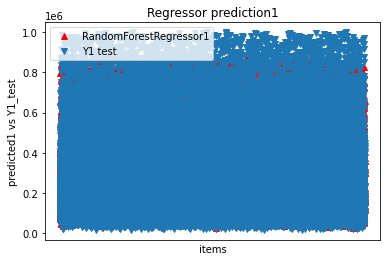

In [202]:
plt.figure()
plt.plot(prediction1, 'r^', label='RandomForestRegressor1')
plt.plot(Y1_test, 'v', label='Y1 test')
plt.tick_params(axis='x', which='both', bottom=False, top=False,
                labelbottom=False)
plt.ylabel('predicted1 vs Y1_test')
plt.xlabel('items')
plt.legend(loc="best")
plt.title('Regressor prediction1')

plt.show()

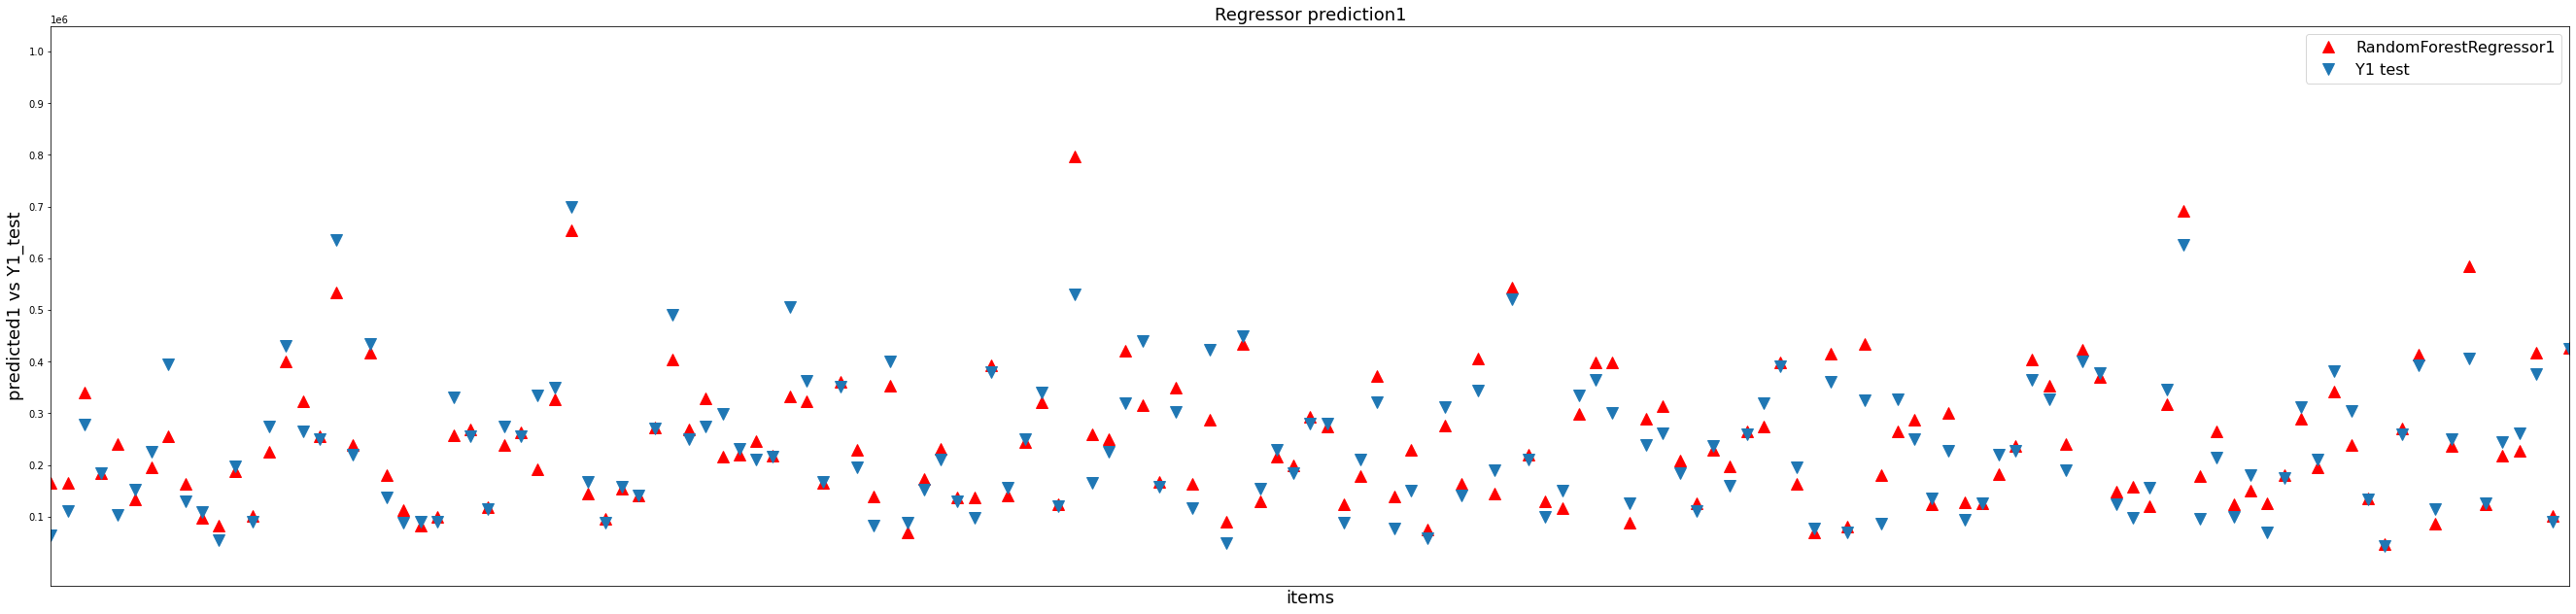

In [203]:
a= plt.figure()
axes= a.add_axes([0,0,6,2])#sequence of [left, bottom, width, height] quantities.
#axes= a.add_axes([0.2,0.2,8,8])
# adding axes
#x= np.arange(0,11)
#axes.plot(prediction, marker='*')
y = np.array([100000, 200000, 300000, 400000, 500000, 600000,700000,800000, 900000, 1000000,1100000,1200000, 1300000,1400000])
plt.yticks(np.arange(y.min(), y.max(), 100000))

axes.plot(prediction1, 'r^', label='RandomForestRegressor1',markersize=12)
axes.plot(Y1_test, 'v', label='Y1 test',markersize=12)
axes.set_xlim([0,150])
plt.tick_params(axis='x', which='both', bottom=False, top=False,
                labelbottom=False)
plt.ylabel('predicted1 vs Y1_test', fontsize=18)
plt.xlabel('items', fontsize=18)
plt.legend(loc="best",prop={'size': 16})
plt.title('Regressor prediction1', fontsize=18)

plt.show()

In [204]:
from sklearn import metrics
from sklearn.metrics import mean_squared_error

In [205]:
mean_squared_error1=metrics.mean_squared_error(prediction1,Y1_test)
mean_squared_error1
root_mse1_2=pow(mean_squared_error1,0.5)
root_mse1_2

61846.28780165557

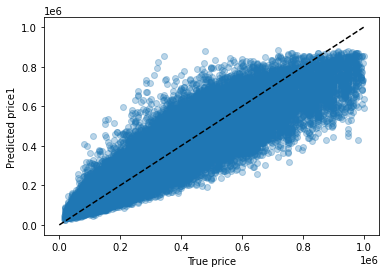

In [206]:
plt.scatter(Y1_test,prediction1,alpha=0.3)
plt.plot([0,1000000],[0,1000000],'--k')
plt.axis('tight')
plt.xlabel('True price')
plt.ylabel('Predicted price1')
plt.show()


In [207]:
mean_squared_error_validation=metrics.mean_squared_error(prediction_validation,Y_Validation)
mean_squared_error_validation
root_msev_2=pow(mean_squared_error_validation,0.5)
root_msev_2

63287.59640652223

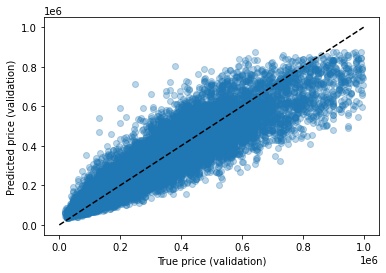

In [208]:
plt.scatter(Y_Validation,prediction_validation,alpha=0.3)
plt.plot([0,1000000],[0,1000000],'--k')
plt.axis('tight')
plt.xlabel('True price (validation)')
plt.ylabel('Predicted price (validation)')
plt.show()